# [NLP] Assignment 1: Tokenization

In this assignment, you need to tokenize the text of the Twitter(X) users posts(tweets). The assignment consists of two tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repo later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

The [data](https://drive.google.com/file/d/15x_wPAflvYQ2Xh38iNQGrqUIWLj5l5Nw/view?usp=share_link) contains 5 files whereby each contains 44 tweets. Each tweet is separated by a newline.

## Reading the data

In [1]:
import os

paths_to_files = os.listdir('data/tweets')

files_data = dict()

for file_path in paths_to_files:
    with open(f'data/tweets/{file_path}', 'r') as file:
        files_data[file_path] = file.readlines()

## Task 1. Tokenize some tweets manually (20 points)

As a first task you need to tokenize first 15 tweets from `file2` by hand. This will allow you to understand the problem from a linguistic point of view. The guidelines for tweet tokenization are as follows:

- Each smiley is a separate token
- Each hashtag is an individual token. Each user reference is an individual token
- If a word has spaces between them then it is converted to a single token
- All punctuations are individual tokens. This includes double-quotes and single quotes also
- A URL is a single token

Example of output

    Input tweet
    @xfranman Old age has made N A T O!

    Tokenized tweet (separated by comma)
    @xfranman , Old , age , has , made , NATO , !


    1. Input tweet
    ...
    1. Tokenized tweet
    ...

    2. Input tweet
    ...
    2. Tokenized tweet
    ...

### Solution

In [2]:
tweets = files_data['file2'][:15]

In [3]:
import re

# Reference: https://stackoverflow.com/a/28077780
smiley_re = re.compile(
    r"(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)")


def tokenize_tweet_by_hand(tweet: str) -> str:
    raw_tokens = tweet.strip().split()

    tokens = []
    for token in raw_tokens:
        if token.startswith('http://') or token.startswith("#") or smiley_re.match(token):
            tokens.append(token)
            continue

        tokens.extend(re.findall(r"[$@\w]+|[.,!?;:\"\'-/>]|<\-\-\-", token))

    return tokens

In [4]:
for i, tweet in enumerate(tweets):
    print(f'{i + 1}. Input tweet\n{tweet}', end='')
    print(f'{i + 1}. Tokenized tweet\n{" , ".join(tokenize_tweet_by_hand(tweet))}\n')

1. Input tweet
Camping in Maine for the weekend. Hey Dad, Mama Loves YOU: http://www.mamapalooza.com
1. Tokenized tweet
Camping , in , Maine , for , the , weekend , . , Hey , Dad , , , Mama , Loves , YOU , : , http://www.mamapalooza.com

2. Input tweet
Its american tradition bitch
2. Tokenized tweet
Its , american , tradition , bitch

3. Input tweet
@ThroughTheVoid They love it! The only pleasure they get in life. I actually do that. I'm sure I hear a tiny squeak... Then louder ones
3. Tokenized tweet
@ThroughTheVoid , They , love , it , ! , The , only , pleasure , they , get , in , life , . , I , actually , do , that , . , I , ' , m , sure , I , hear , a , tiny , squeak , . , . , . , Then , louder , ones

4. Input tweet
" RT @latti: @AbsoHilare stop tweeting in church! Lol <--- ""I tweet because I'm happy, I tweet because I'm free"" LOL!"
4. Tokenized tweet
" , RT , @latti , : , @AbsoHilare , stop , tweeting , in , church , ! , Lol , <--- , " , " , I , tweet , because , I , ' , m , ha

## Task 2. Implement [Byte-Pair Encoding(BPE)](https://arxiv.org/pdf/1508.07909.pdf) Tokenizer (80 points)

### Task 2.1. Implementation (60 points)

Implement the tokenizer as the BPETokenizer class:
* Implement `train` method that learns merges and builds the vocabulary of the specified `vocab_size` (25 points).
* Implement `tokenize` method that should tokenize the text according to the learnt merges (25 points).

Your code should have docstrings and comments (10 points).

In [5]:
from typing import List
from collections import Counter


class BPETokenizer:
    """
    Byte-Pair Encoding Tokenizer
    """

    def __init__(self, vocab_size: int) -> None:
        """
        Initializing the tokenizer. 
        :param vocab_size: controls the target vocabulary size
        """
        self.vocab_size = vocab_size

        self.vocab = None
        self.corpus = None

    def preprocess_corpus(self, corpus: List[str]) -> Counter:
        """
        Preprocess the corpus. Splits the words into characters and adds a special character at the end of each word.
        :param corpus: list of texts
        :return: Counter of the preprocessed corpus
        """
        new_corpus = Counter()

        for text in corpus:
            text = text.lower().strip()
            tokens = text.split()
            for token in tokens:
                new_corpus[' '.join(list(token)) + ' _'] += 1

        return new_corpus

    def build_vocab(self) -> Counter:
        """
        Builds the vocabulary from the corpus. 
        :return: Counter of the vocabulary
        """
        vocab = Counter()
        for token in self.corpus:
            vocab.update(token.split())

        return vocab

    def train(self, corpus: List[str]) -> None:
        """
        Trains the tokenizer on the corpus.
        :param corpus: list of texts
        """
        self.corpus = self.preprocess_corpus(corpus)

        self.vocab = self.build_vocab()

        if self.vocab_size is None:
            self.vocab_size = len(self.vocab)

        while len(self.vocab) < self.vocab_size:
            # Get the pairs and their counts
            pairs = self._get_stats()
            if not pairs:
                break

            # Get the most frequent pair
            best_pair = max(pairs, key=pairs.get)

            # Merge the most frequent pair
            self._merge_vocab(best_pair)

    def _get_stats(self) -> Counter:
        """
        Get the statistics of the pairs in the corpus.
        :return: Counter of the pairs
        """
        pairs = Counter()
        for token in self.corpus:
            symbols = token.split()
            for i in range(len(symbols) - 1):
                pairs[symbols[i], symbols[i + 1]] += self.corpus[token]

        return pairs

    def _merge_vocab(self, pair: List[str]) -> None:
        """
        Merges the most frequent pair in the vocabulary.
        :param pair: pair to merge
        """
        new_corpus = Counter()
        for token in self.corpus:
            new_token = token.replace(' '.join(pair), ''.join(pair))
            new_corpus[new_token] = self.corpus[token]

        self.corpus = new_corpus
        self.vocab = self.build_vocab()

    def tokenize(self, text: str) -> List[str]:
        """
        Tokenizes the text.
        :param text: text to tokenize
        :return: list of tokens
        """
        text = text.lower().strip()
        tokens = text.split()

        new_tokens = []
        for token in tokens:
            i, j = 0, 0
            while i < len(token):
                j = i + 1

                while j <= len(token) and token[i:j] in self.vocab:
                    j += 1

                subtoken = token[i:j - 1]
                new_tokens.append(subtoken)
                i = j - 1

        return new_tokens

### Task 2.2. Analysis on Tweets Dataset (10 points)

Train the BPE tokenizer on the tweets dataset. Try to tokenize the tweets with the tokenizer of different `vocab_size`. For example, train the BPE tokenizer with `vocab_size` of [base_vocab_size, 250, 500, 750, 1000]. Plot the dependency of the average length of the tokenized tweet by `vocab_size` to analyze how `vocab_size` affects the length of the tokenized tweet on average. Tell what `vocab_size` is preferrable and why.

In [6]:
corpus = []
[corpus.extend(tweets) for tweets in files_data.values()]

vocab_sizes = [None, 250, 500, 750, 1000]

tokenized_tweets = {vocab_size: [] for vocab_size in vocab_sizes}

for vocab_size in vocab_sizes:
    tokenizer = BPETokenizer(vocab_size)
    tokenizer.train(corpus)

    if vocab_size is None:
        vocab_size = len(tokenizer.vocab)
        tokenized_tweets[vocab_size] = []

    print("Trained tokenizer for vocab size:", vocab_size)

    for tweet in corpus:
        tokenized_tweets[vocab_size].append(tokenizer.tokenize(tweet))

Trained tokenizer for vocab size: 138
Trained tokenizer for vocab size: 250
Trained tokenizer for vocab size: 500
Trained tokenizer for vocab size: 750
Trained tokenizer for vocab size: 1000


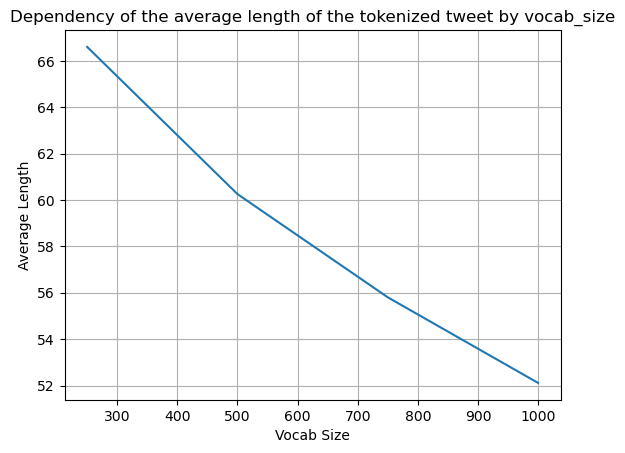

In [7]:
import matplotlib.pyplot as plt

avg_lengths = []

for vocab_size, tweets in sorted(tokenized_tweets.items(), key=lambda x: x[0] if x[0] is not None else 0):
    if not tweets:
        continue

    lengths = [len(tweet) for tweet in tweets]
    avg_length = sum(lengths) / len(tweets)
    avg_lengths.append(avg_length)

plt.title('Dependency of the average length of the tokenized tweet by vocab_size')
plt.xlabel('Vocab Size')
plt.ylabel('Average Length')
plt.grid()
plt.plot(vocab_sizes, avg_lengths)

plt.show()

#### Which `vocab_size` is preferrable and why?

In my opinion, the prefferable `vocab_size` is 750. It provides a good balance between the average length of the tokenized tweet and the vocabulary size. It is not too small to lose the information and not too large to make the model overfit.

### Task 2.3. Analysis on Dataset of Different Language (10 points)

Find a small dataset of texts in a language other than English. The dataset size should be not greater than several megabytes.

Train the BPE tokenizer on the dataset that you found. Try to tokenize the sentences from this dataset with the tokenizer of different `vocab_size`. Plot the dependency of the average length of the tokenized sentence by `vocab_size` to analyze how `vocab_size` affects the length of the tokenized sentence on average.

Tell how how the average length of the tokenized sentence differs from the average length of the tokenized tweet. Explain why. 

In [8]:
import pandas as pd

# TextComplexityDE is a dataset consisting of 1000 sentences in German language taken from 23 Wikipedia articles in 3 different article-genres
texts_df = pd.read_csv("data/TextComplexityDE/source.csv", encoding='iso-8859-1')

In [9]:
corpus = texts_df.Sentence.values.tolist()

In [10]:
tokenized_texts = {vocab_size: [] for vocab_size in vocab_sizes}

for vocab_size in vocab_sizes:
    tokenizer = BPETokenizer(vocab_size)
    tokenizer.train(corpus)

    if vocab_size is None:
        vocab_size = len(tokenizer.vocab)
        tokenized_texts[vocab_size] = []

    print("Trained tokenizer for vocab size:", vocab_size)

    for text in corpus:
        tokenized_texts[vocab_size].append(tokenizer.tokenize(text))

Trained tokenizer for vocab size: 75
Trained tokenizer for vocab size: 250
Trained tokenizer for vocab size: 500
Trained tokenizer for vocab size: 750
Trained tokenizer for vocab size: 1000


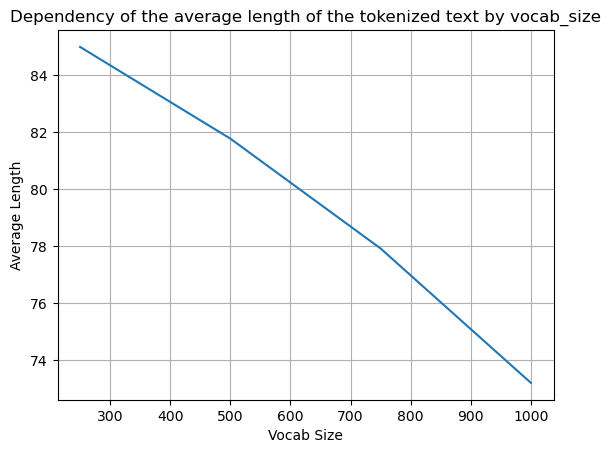

In [11]:
import matplotlib.pyplot as plt

avg_lengths = []

for vocab_size, texts in sorted(tokenized_texts.items(), key=lambda x: x[0] if x[0] is not None else 0):
    if not texts:
        continue

    lengths = [len(text) for text in texts]
    avg_length = sum(lengths) / len(texts)
    avg_lengths.append(avg_length)

plt.title('Dependency of the average length of the tokenized text by vocab_size')
plt.xlabel('Vocab Size')
plt.ylabel('Average Length')
plt.grid()
plt.plot(vocab_sizes, avg_lengths)

plt.show()

#### How the average length of the tokenized sentence differs from the average length of the tokenized tweet?

The average length of the tokenized sentence is much larger than the average length of the tokenized tweet. This is because the German language has a more complex structure than the English language. The German language has more complex words and more complex grammar. This results in a larger vocabulary and a larger average length of the tokenized sentence.